<a href="https://colab.research.google.com/github/bhas10bc/tensor_flow_course/blob/main/DCGAN_By_Neuralearn_ai_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

# Data

## Download Data

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip "/content/celeba-dataset.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/dat

## Prepare Data

In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4
LATENT_DIM=100
EPOCHS=20

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 202599 files belonging to 1 classes.


In [ ]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    dataset
    .map(preprocess)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


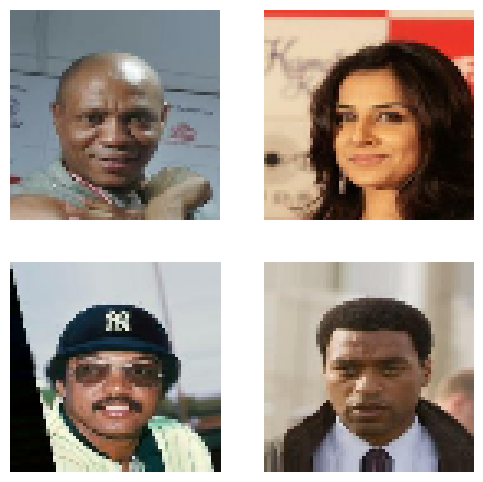

In [ ]:
plt.figure(figsize = (6,6))
k=0
n = 4
for i in range(n):
  ax = plt.subplot(2,2, k+1)
  plt.imshow((d[i]+1)/2)
  plt.axis("off")
  k+=1

# MOdeling

In [ ]:
generator=tf.keras.Sequential([
  Input(shape=(LATENT_DIM,)),
  Dense(4*4*LATENT_DIM),
  Reshape((4,4,LATENT_DIM)),

  Conv2DTranspose(512,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2DTranspose(3,kernel_size=4,strides=2, activation=tf.keras.activations.tanh, padding='same'),

],name='generator')

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        819712    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      20

In [ ]:
discriminator=tf.keras.Sequential([
  Input(shape=(IM_SHAPE[0],IM_SHAPE[1],3)),

  Conv2D(64,kernel_size=4,strides=2, padding='same'),
  LeakyReLU(0.2),

  Conv2D(128,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(256,kernel_size=4,strides=2, padding='same'),
  BatchNormalization(),
  LeakyReLU(0.2),

  Conv2D(1,kernel_size=4,strides=2, padding='same'),

  Flatten(),
  Dense(1,activation='sigmoid')


],name='discriminator')

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                     

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        out=self.model.generator(tf.random.normal(shape=(36, self.latent_dim)))
        plt.figure(figsize=(16,16))
        for i in range(n):
          for j in range(n):
            ax=plt.subplot(n,n,k+1)
            plt.imshow((out[k]+1)/2,)
            plt.axis('off')
            k+=1
        plt.savefig("generated/gen_images_epoch_{}.png".format(epoch+1))

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self,discriminator,generator):
    super(GAN,self).__init__()
    self.discriminator=discriminator
    self.generator=generator

  def compile(self,d_optimizer,g_optimizer,loss_fn):
    super(GAN,self).compile()
    self.d_optimizer=d_optimizer
    self.g_optimizer=g_optimizer
    self.loss_fn=loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric,self.g_loss_metric]

  def train_step(self,real_images):
    batch_size=tf.shape(real_images)[0]

    ######## Discriminator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    fake_images=self.generator(random_noise)

    real_labels=tf.ones((batch_size,1))+0.25*tf.random.uniform((batch_size,1),minval=-1,maxval=1)
    fake_labels=tf.zeros((batch_size,1))+0.25*tf.random.uniform((batch_size,1),)

    with tf.GradientTape() as recorder:
      real_predictions=self.discriminator(real_images)
      d_loss_real=self.loss_fn(real_labels,real_predictions)

      fake_predictions=self.discriminator(fake_images)
      d_loss_fake=self.loss_fn(fake_labels,fake_predictions)

      d_loss=d_loss_real+d_loss_fake

    partial_derivatives = recorder.gradient(d_loss,self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(partial_derivatives, self.discriminator.trainable_weights))

    ############# Generator
    random_noise=tf.random.normal(shape=(batch_size,LATENT_DIM))
    flipped_fake_labels=tf.ones((batch_size,1))

    with tf.GradientTape() as recorder:

      fake_predictions=self.discriminator(self.generator(random_noise))
      g_loss=self.loss_fn(flipped_fake_labels,fake_predictions)

    partial_derivatives = recorder.gradient(g_loss,self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(partial_derivatives, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss':self.d_loss_metric.result(),
            'g_loss':self.g_loss_metric.result()}

In [ ]:
gan=GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(),
)

In [ ]:
!mkdir generated

In [ ]:
EPOCHS=1000
history=gan.fit(train_dataset,epochs=EPOCHS,callbacks=[ShowImage(LATENT_DIM)])

Epoch 1/1000
      6/Unknown - 25s 182ms/step - d_loss: 1.1782 - g_loss: 0.6507

     55/Unknown - 34s 187ms/step - d_loss: 0.7004 - g_loss: 1.0504

KeyboardInterrupt: ignored

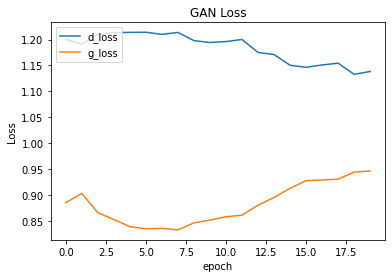

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()